<a href="https://colab.research.google.com/github/mz-zarei/TimeSeriesAnalysis/blob/main/PedestrianFlowForecasting/PedestrianFlowForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pedestrian/Bicycle Flow Forecasting**
In this notebook, a comprehensive **Time Series Analysis** are conducted over pedestrian/bicycle hourly count __[open data set](http://pandas.pydata.org/pandas-docs/stable/index.html)__ collected from Burke Gilman Trail north of NE 70th St, Seattle, US. 

Key steps are as follows:
- Setting up the data set and performing EDA
- 

In [ ]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os

# ignore warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline


import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import fbprophet
!pip install pmdarima
import pmdarima as pm      # this helps to automate parameter tuning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 1- Setting up the data set and performing EDA

In [2]:
# load data and convert to datetime
df = pd.read_csv('./Burke_Gilman_Trail_north_of_NE_70th_St_Bicycle_and_Pedestrian_Counter.csv', 
                           infer_datetime_format=True, 
                           index_col=0, engine='python')
print(df.columns)

# change the index to pandas datetime object
df.index = pd.to_datetime(df.index)

# drop the unused columns
df.drop(columns=['Ped South','Ped North','Bike North','Bike South'],
              inplace=True)
df.rename(columns={'BGT North of NE 70th Total':'PedBikeCount'}, inplace=True)

Index(['BGT North of NE 70th Total', 'Ped South', 'Ped North', 'Bike North',
       'Bike South'],
      dtype='object')


In [3]:
# Check if there is any Null target values
print('Number of null values (before): {0}'.format(df.PedBikeCount.isnull().sum()))
# Fill null values with zero
df.fillna(value=0, inplace=True)
print('Number of null values (after): {0}'.format(df.PedBikeCount.isnull().sum()))

Number of null values (before): 2346
Number of null values (after): 0


In [4]:
# Check for duplicate index values
print('Duplicate dates in our data (before): ', df.index.duplicated().sum())
# Drop duplicate index values
df = df[~df.index.duplicated(keep='first')]
print('Duplicate dates in our data (after): ', df.index.duplicated().sum())

Duplicate dates in our data (before):  720
Duplicate dates in our data (after):  0


In [5]:
# Check for missing index values
print('Unique dates in our data (before): ', len(df.index.unique()), 'hours')
## Calculate number of hours in date range
our_date_range = df.index.max() - df.index.min()
print('Total hours in our date range:', our_date_range.total_seconds()/3600+1, 'hours')
# Generate complete date range
new_index = pd.date_range(df.index.min(), df.index.max(), freq="1h")
# Reindex the data set
df_new = df.reindex(new_index, fill_value=0)
print('Unique dates in our data (after): ', len(df_new.index.unique()), 'hours')
print(df_new.index)

Unique dates in our data (before):  63936 hours
Total hours in our date range: 73008.0 hours
Unique dates in our data (after):  73008 hours
DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 01:00:00',
               '2014-01-01 02:00:00', '2014-01-01 03:00:00',
               '2014-01-01 04:00:00', '2014-01-01 05:00:00',
               '2014-01-01 06:00:00', '2014-01-01 07:00:00',
               '2014-01-01 08:00:00', '2014-01-01 09:00:00',
               ...
               '2022-04-30 14:00:00', '2022-04-30 15:00:00',
               '2022-04-30 16:00:00', '2022-04-30 17:00:00',
               '2022-04-30 18:00:00', '2022-04-30 19:00:00',
               '2022-04-30 20:00:00', '2022-04-30 21:00:00',
               '2022-04-30 22:00:00', '2022-04-30 23:00:00'],
              dtype='datetime64[ns]', length=73008, freq='H')


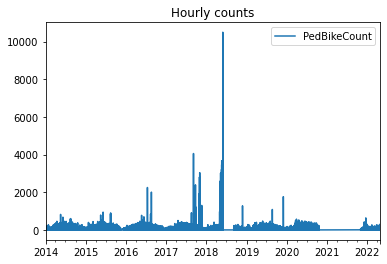

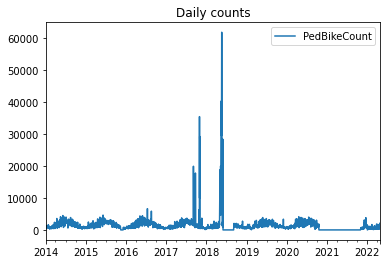

In [6]:
display(df_new.plot(title='Hourly counts'))
display(df_new.resample('D').sum().plot(title='Daily counts'))

Based on the above plots, we can see that there are many zero counts between 2021 and 2022 which can be due to broken sensors. Also there are few very unusual spikes around 2018 which can be either due to some competition or again broken censors. For the sake of this project we will just focus on the daily counts of the first year of the data set (2014). 

In [7]:
df_new = df_new[df_new.index <'2015-10-01 00:00:00']
df_new = df_new.resample('D').sum()
df_new_weekly = df_new.resample('W').sum()
df_new_monthly = df_new.resample('M').sum()

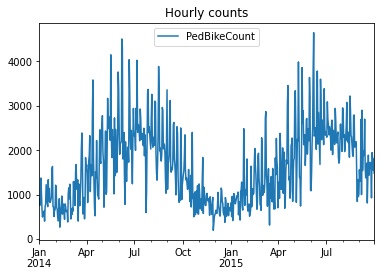

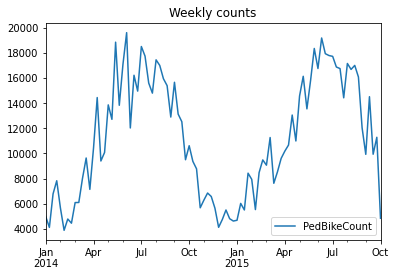

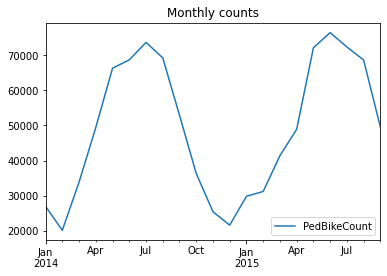

In [8]:
display(df_new.plot(title='Hourly counts'))
display(df_new_weekly.plot(title='Weekly counts'))
display(df_new_monthly.plot(title='Monthly counts'))

In [9]:
print('start date: {0}'.format(df_new.index.min()))
print('end date:   {0}'.format(df_new.index.max()))
df_new.describe()

start date: 2014-01-01 00:00:00
end date:   2015-09-30 00:00:00


,PedBikeCount
count,638.0
mean,"1,622.5"
std,837.5
min,196.0
25%,906.8
50%,"1,523.5"
75%,"2,229.8"
max,"4,643.0"


## 2- Identifying Stationarity 

1. Run-sequence plots
2. Rolling Averages and Windows
3. Summary statistics & histogram plots
4. Augmented Dickey-Fuller test

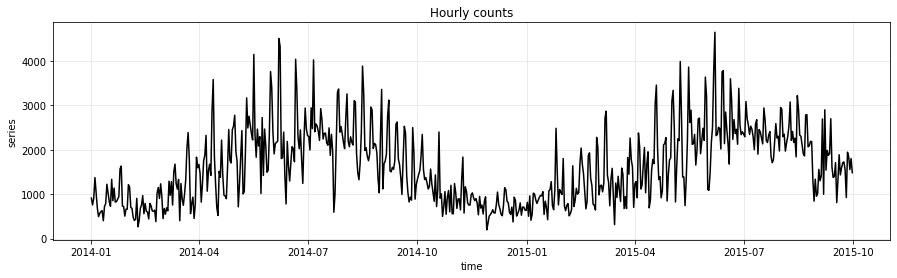

In [10]:
# Run-sequence plots
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.rcParams["figure.figsize"] = (15,4)
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)

run_sequence_plot(df_new.index, df_new.PedBikeCount, 'Hourly counts')

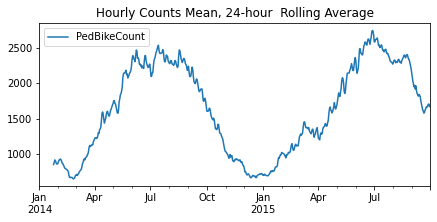

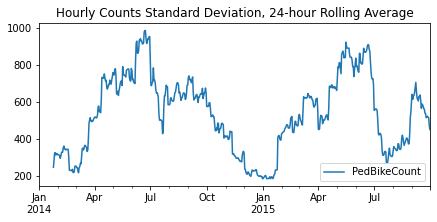

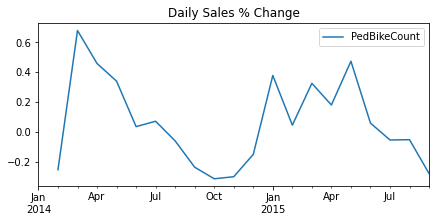

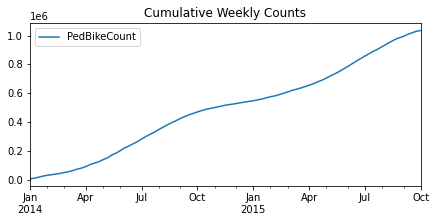

In [11]:
plt.rcParams["figure.figsize"] = (7,3)

# Rolling average and windows
window_size = 24
rolling_window = df_new.rolling(window_size)
rolling_window.mean().plot(title='Hourly Counts Mean, 24-hour  Rolling Average')
rolling_window.std().plot(title='Hourly Counts Standard Deviation, 24-hour Rolling Average')

# Monthly Count Percent Change
df_new_monthly.pct_change().plot(title='Daily Sales % Change')

# Cumulative Weekly Counts
df_new_weekly.cumsum().plot(title='Cumulative Weekly Counts')

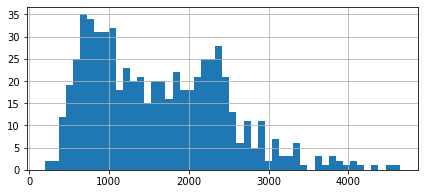

In [12]:
# Histogram plot
df_new.PedBikeCount.hist(bins=50)

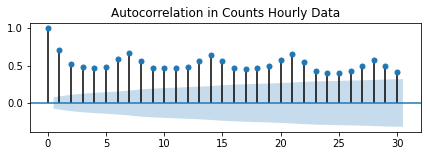

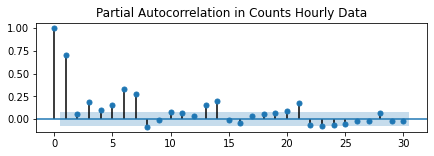

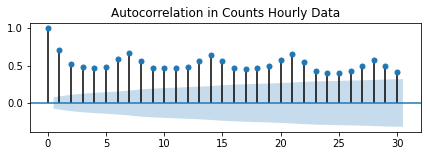

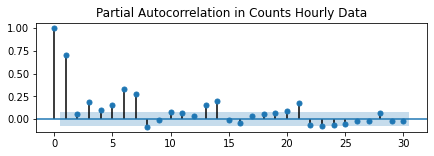

In [13]:
# ACF, PACF, Monthly plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
plt.rcParams["figure.figsize"] = (7,2)

# Hourly data Autocorrelation Plots
acf_plot = plot_acf(df_new.PedBikeCount, lags=30, title='Autocorrelation in Counts Hourly Data')
pacf_plot = plot_pacf(df_new.PedBikeCount, lags=30, title='Partial Autocorrelation in Counts Hourly Data')

# Daily data Autocorrelation Plots
acf_plot = plot_acf(df_new.PedBikeCount, lags=30, title='Autocorrelation in Counts Hourly Data')
pacf_plot = plot_pacf(df_new.PedBikeCount, lags=30, title='Partial Autocorrelation in Counts Hourly Data')

# Monthly Data Seasonal Plot
# m_plot = month_plot(df_new_monthly.PedBikeCount)

In [14]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_new.iloc[:,0].values)
print("ADF: ", adf)
print("p-value:", pvalue)
print("crit values: ", critical_values)

ADF:  -1.4279542563922167
p-value: 0.5688035728473281
crit values:  {'1%': -3.440992973242412, '5%': -2.8662357332485353, '10%': -2.569270733669741}


Based on above results, we can see that the data is not stationary (variable variance and mean) and also has clear seasonality.

## 3- Transform Data to be Stationary

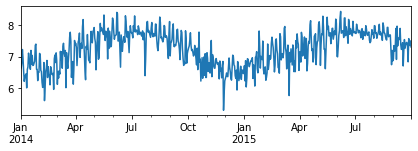

In [15]:
# Log transformation for variance changing 
df_new_log_transformed = np.log1p(df_new.PedBikeCount)
df_new_log_transformed.plot()

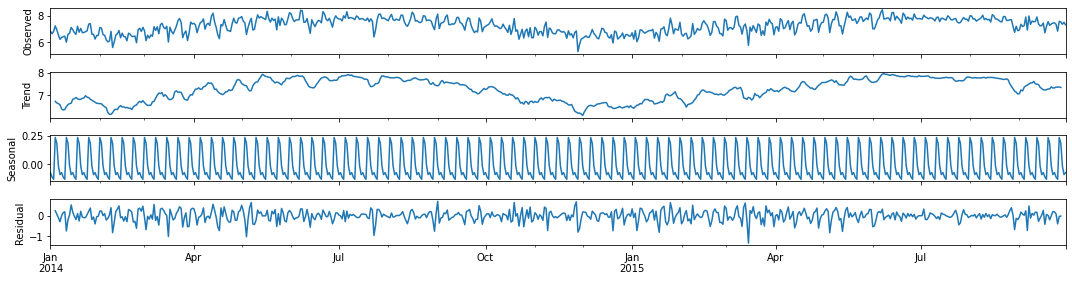

In [35]:
# Remove Trend & Seasonality with Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# ss_decomposition = seasonal_decompose(x=df_new.PedBikeCount.values, model='additive', freq=7)
ss_decomposition = seasonal_decompose(x=df_new_log_transformed, model='additive', freq=7)

est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_residual = ss_decomposition.resid

seasonal_decompose(df_new_log_transformed,freq=7).plot()

In [17]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(est_residual[15:-15])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)
print("crit values: ", critical_values_)

ADF:  -11.982723491945258
p-value:  3.6727720788297005e-22
crit values:  {'1%': -3.44152019959894, '5%': -2.8664679191981297, '10%': -2.569394451038919}


## 4- Triple Exponential Smoothing

Triple Smooting MSE:  0.11691185906840829


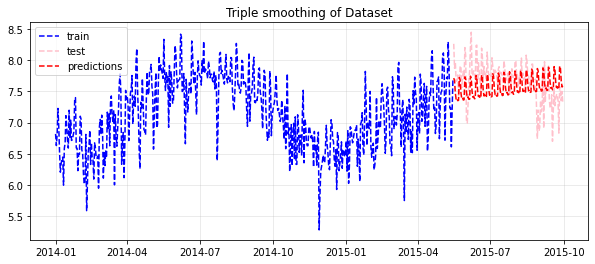

In [231]:
from statsmodels.tsa.api import ExponentialSmoothing
train = df_new_log_transformed[:500]
test = df_new_log_transformed[500:]
triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=7).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mean_squared_error(test, triple_preds)
print("Triple Smooting MSE: ", triple_mse)

plt.plot(df_new[:500].index, train, 'b--', label="train")
plt.plot(df_new[500:].index, test, color='pink', linestyle="--", label="test")
plt.plot(df_new[500:].index, triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple smoothing of Dataset")
plt.grid(alpha=0.3)
plt.show()

## 5- Forecasting Using SARIMA model


In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.relativedelta import relativedelta

# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

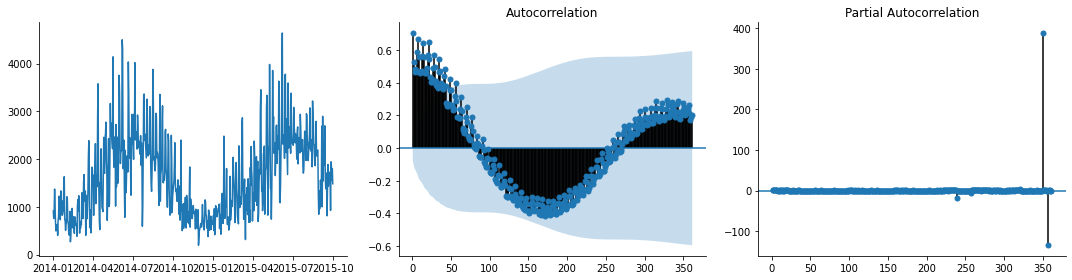

In [78]:
plots(df_new.PedBikeCount, lags=361)

In [114]:
# Find parameters for SARIMA model
stepwise_model = pm.auto_arima(train, start_p=1, start_q=1,
                                max_p=2, max_q=2, m=7,
                                start_P=0, seasonal=True,
                                d=1, D=0, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True, information_criterion ='aic')
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=434.945, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=595.618, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=554.858, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=482.581, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=593.626, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=440.132, Time=0.42 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=414.993, Time=2.03 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=432.654, Time=1.02 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=404.456, Time=3.46 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=421.426, Time=2.75 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=405.337, Time=4.68 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=415.751, Time=3.79 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=435.850, Time=3.34 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=409.016, 

In [125]:
# fit SARIMA 
sarima_model = sm.tsa.statespace.SARIMAX(train, 
                                         order=(1,1,1), 
                                         seasonal_order=(1,0,1,7), 
                                         trend='c').fit()
sarima_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                      PedBikeCount   No. Observations:                  500
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -201.496
Date:                           Wed, 04 May 2022   AIC                            414.993
Time:                                   23:18:52   BIC                            440.268
Sample:                               01-01-2014   HQIC                           424.912
                                    - 05-15-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.885      0.376      -0.000       0.001
ar.L1          0.4012      0.041      9.807      0.000       0.321       0.481
ma.L1         -0.9667      0.010   -100.315      0.000      -0.986      -0.948
ar.S.L7        0.8297      0.079     10.474      0.000       0.674       0.985
ma.S.L7       -0.6726      0.108     -6.224      0.000      -0.884      -0.461
sigma2         0.1281      0.007     18.572      0.000       0.115       0.142
===================================================================================
Ljung-Box (Q):                       58.07   Jarque-Bera (JB):                48.82
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.53
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

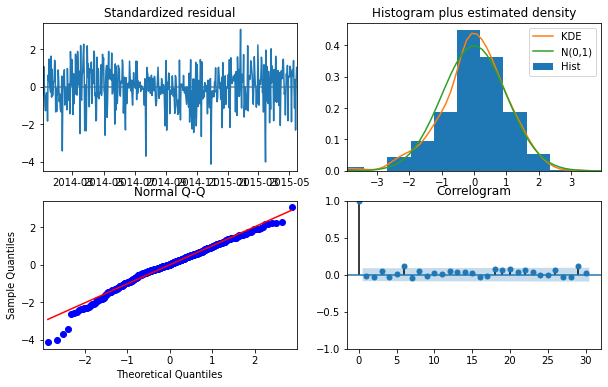

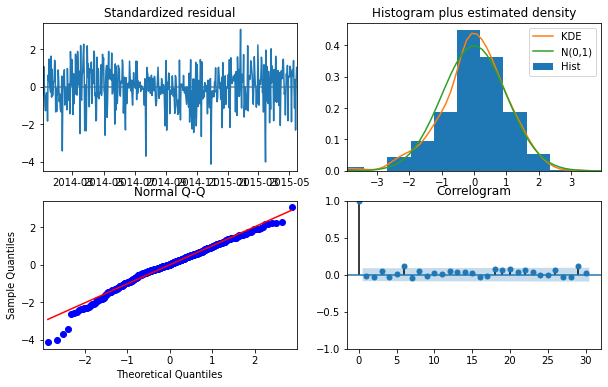

In [126]:
sarima_model.plot_diagnostics(lags=30,figsize = (10,6))

SARIMA MSE:  0.11703054204463509


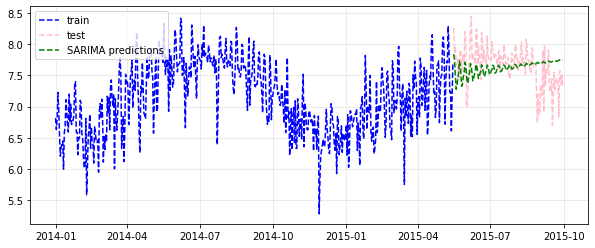

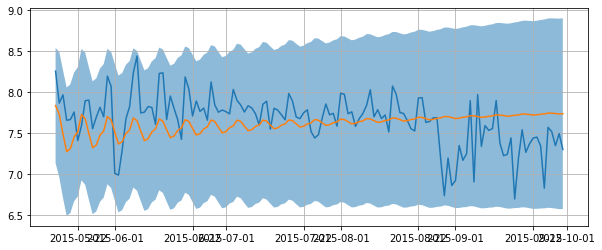

In [230]:
# use get_forecast to create a forecast object
sarima_preds = sarima_model.get_forecast(len(test))
# That will have a method to pull in confidence interval 
confidence_int = sarima_preds.conf_int(alpha = 0.05)
# Has an attribute to pull in predicted mean
sarima_preds = sarima_preds.predicted_mean
# MSE error
sarima_mse = mean_squared_error(test, sarima_preds)
print("SARIMA MSE: ", sarima_mse)

# Plot predictions 
plt.plot(df_new[:500].index, train, 'b--', label="train")
plt.plot(df_new[500:].index, test, color='pink', linestyle="--", label="test")
plt.plot(df_new[500:].index, sarima_preds, 'g--', label="SARIMA predictions")
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

# Plot predictions and confidence intervals
plt.plot(test)
plt.plot(sarima_preds)
plt.fill_between(confidence_int.index,confidence_int['lower PedBikeCount'],confidence_int['upper PedBikeCount'],alpha = 0.5)
plt.grid()

## 6- Forcasting using Facebook's Prophet model

In [179]:
# Prepare the data set
fb_train = pd.DataFrame(data={'ds':df_new[:500].index.values,
                              'y' :np.log(df_new[:500].PedBikeCount.values)})

prophet_model = fbprophet.Prophet(yearly_seasonality=True,
                                  daily_seasonality=True)
# prophet_model.add_seasonality(name='monthly', period=30, fourier_order=5)

prophet_model.fit(fb_train)
future = prophet_model.make_future_dataframe(periods=len(test))
prophet_perdiction = prophet_model.predict(future)

prophet_preds = prophet_perdiction[500:].yhat
print('Prophet model MSE = ', mean_squared_error(test, prophet_preds))

Prophet model MSE =  0.07478371895281652


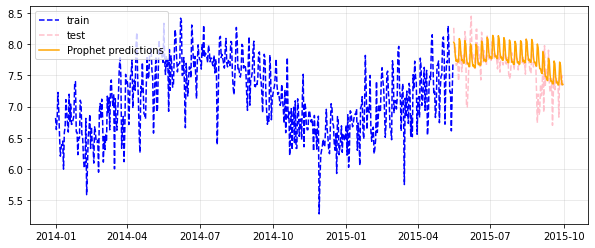

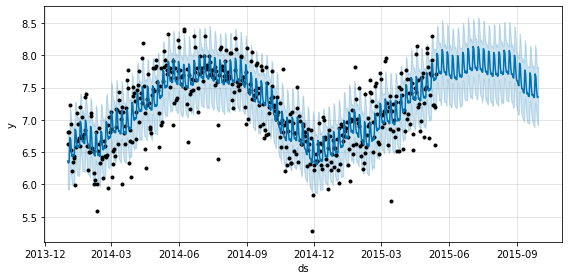

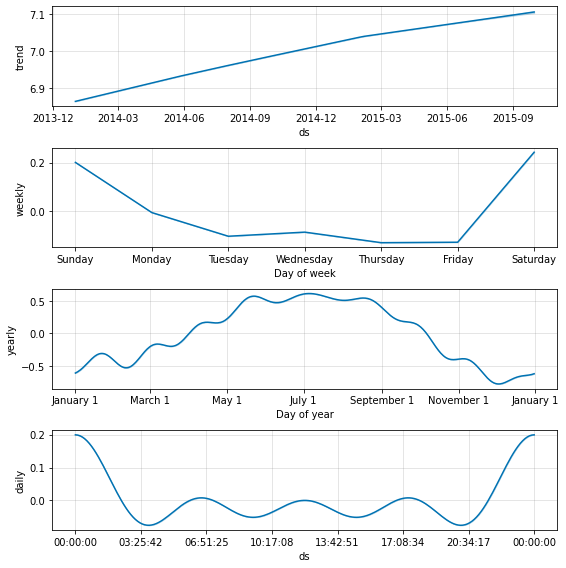

In [229]:
# Plot predictions
plt.rcParams["figure.figsize"] = (10,4)

plt.plot(df_new[:500].index, train, 'b--', label="train")
plt.plot(df_new[500:].index, test, color='pink', linestyle="--", label="test")
plt.plot(df_new[500:].index, prophet_preds, 'orange', label="Prophet predictions")

plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

prophet_model.plot(prophet_perdiction, figsize=(8,4))
plt.show()

prophet_model.plot_components(prophet_perdiction, figsize=(8,8))
plt.show()


## 7- Forcasting using LSTM/GRU model

In [216]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_days, 
                        train_days, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_days (int): length of sequence input to network 
    train_days (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 3
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    train = df[:train_days][series_name].values 
    test  = df[train_days:][series_name].values 

    train_X, train_y = [], []

    # range 0 through # of train samples - input_days by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_days, sample_gap): 
        train_X.append(train[i:i+input_days]) # each training sample is of length input hours
        train_y.append(train[i+input_days]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[-input_days:] 
    test_y = test      
    
    return train_X, test_X_init, train_y, test_y

def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

def fit_GRU(train_X, train_y, cell_units, epochs):
    """
    Fit GRU to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for GRU cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a GRU layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(Bidirectional(GRU(cell_units, input_shape=(train_X.shape[1],1))))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

In [206]:
df_new['log_y'] = df_new_log_transformed
series_days = len(df_new.PedBikeCount.values)
input_days = 30
train_days = len(train)

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_new, 'log_y', series_days, 
                         input_days, train_days,
                         sample_gap=2))
    
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (235, 30, 1)
Training output shape: (235,)
Test input shape: (30,)
Test output shape: (138,)


In [ ]:
GRU_model  = fit_GRU (train_X, train_y, cell_units=100, epochs=500) 
LSTM_model = fit_LSTM(train_X, train_y, cell_units=100, epochs=500) 

GRU model MSE  =  0.15713151163909633
LSTM model MSE =  0.7012095998331809


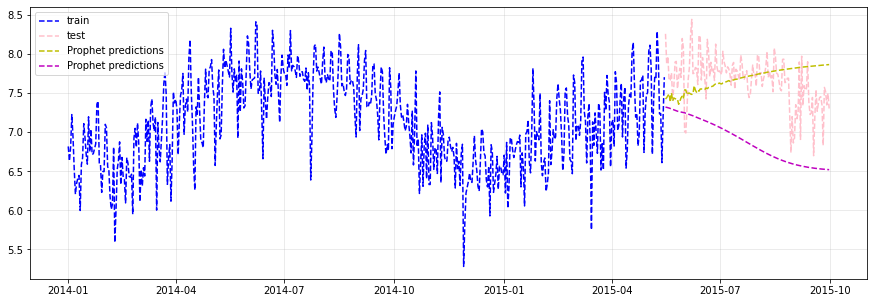

In [228]:
GRU_preds  = predict(test_X_init, len(test), GRU_model)
LSTM_preds = predict(test_X_init, len(test), LSTM_model)

print('GRU model MSE  = ', mean_squared_error(test, GRU_preds))
print('LSTM model MSE = ', mean_squared_error(test, LSTM_preds))

# Plot predictions
plt.rcParams["figure.figsize"] = (15,5)

plt.plot(df_new[:500].index, train, 'b--', label="train")
plt.plot(df_new[500:].index, test, color='pink', linestyle="--", label="test")
plt.plot(df_new[500:].index, GRU_preds, 'y--', label="Prophet predictions")
plt.plot(df_new[500:].index, LSTM_preds, 'm--', label="Prophet predictions")

plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()


## 8- Forcasting using XGBoost

In [213]:
def featurize(t, y_name):
    X = pd.DataFrame()

    X['day']   = t.index.day
    X['month'] = t.index.month
    X['quatter'] = t.index.quarter
    X['dayOfWeek'] = t.index.dayofweek
    X['dayOfYear'] = t.index.dayofyear
    X['dayOfWeek'] = t.index.dayofweek
    X['weekOfYear'] = t.index.weekofyear

    y = t[y_name].values
    return X, y


In [217]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

X_train, y_train = featurize(df_new[:500], y_name='log_y')
X_test, y_test   = featurize(df_new[500:], y_name='log_y')

# Scale X values

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

[00:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.99612	validation_1-rmse:6.50975
[1]	validation_0-rmse:5.40323	validation_1-rmse:5.91472
[2]	validation_0-rmse:4.8694	validation_1-rmse:5.34767
[3]	validation_0-rmse:4.38886	validation_1-rmse:4.83183
[4]	validation_0-rmse:3.95658	validation_1-rmse:4.37392
[5]	validation_0-rmse:3.56757	validation_1-rmse:3.95472
[6]	validation_0-rmse:3.21771	validation_1-rmse:3.57866
[7]	validation_0-rmse:2.90326	validation_1-rmse:3.24551
[8]	validation_0-rmse:2.62032	validation_1-rmse:2.93863
[9]	validation_0-rmse:2.3666	validation_1-rmse:2.68236
[10]	validation_0-rmse:2.13805	validation_1-rmse:2.42555
[11]	validation_0-rmse:1.93294	validation_1-rmse:2.20031
[12]	validation_0-rmse:1.74859	validation_1-rmse:2.00413
[13]	validation_0-rmse:1.58315	validation_1-rmse:1.82035
[14]	validation_0-rmse:1.43478	validation_1-rmse:1.65058
[15]	validation_0-rmse:1.30159

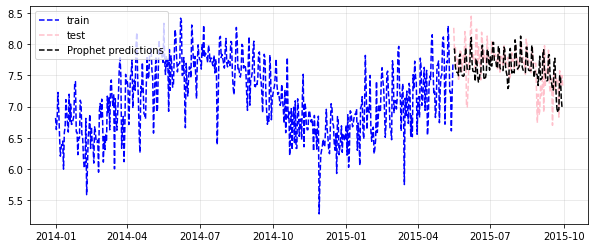

In [227]:
XGBoost_model = XGBRegressor(n_estimators=100)
XGBoost_model.fit(X=X_train_scaled, y=y_train,
                  eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
                  verbose=True)
XGBoost_preds = XGBoost_model.predict(X_test_scaled)

print('XGBoost model MSE = ', mean_squared_error(test, XGBoost_preds))

# Plot predictions
plt.rcParams["figure.figsize"] = (10,4)

plt.plot(df_new[:500].index, train, 'b--', label="train")
plt.plot(df_new[500:].index, test, color='pink', linestyle="--", label="test")
plt.plot(df_new[500:].index, XGBoost_preds, 'k--', label="Prophet predictions")

plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()


## 9- Summary

In [232]:
print('Triple Smoothing model MSE = ', mean_squared_error(test, triple_preds))
print('SARIMA model MSE           = ', mean_squared_error(test, sarima_preds))
print('FB Prophet model MSE       = ', mean_squared_error(test, prophet_preds))
print('GRU model MSE              = ', mean_squared_error(test, GRU_preds))
print('LSTM model MSE             = ', mean_squared_error(test, LSTM_preds))
print('XGBoost model MSE          = ', mean_squared_error(test, XGBoost_preds))


Triple Smoothing model MSE =  0.11691185906840829
SARIMA model MSE           =  0.11703054204463509
FB Prophet model MSE       =  0.07478371895281652
GRU model MSE              =  0.15713151163909633
LSTM model MSE             =  0.7012095998331809
XGBoost model MSE          =  0.07893988678098873
